In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import numpy as np
import pandas as pd
import vice
import seaborn as sns

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import surp
from surp import gce_math as gcem
import arya

In [83]:
model_dir = "../models/A_f0.2_zeta_agb-0.1_t_d0.15_tau_agb0.3//"
#model_dir = "../models/C11_f0.0"
model_dir = "../models/C11_f0.2/"

In [84]:
fiducial = surp.ViceModel.from_saved(model_dir + "/model.json")

In [85]:
yp = surp.yields.YieldParams.from_file(model_dir + "/yield_params.json")
surp.yields.set_yields(yp)

In [86]:
MH = np.linspace(-4, 0.5, 1000)
Z = gcem.MH_to_Z(MH)

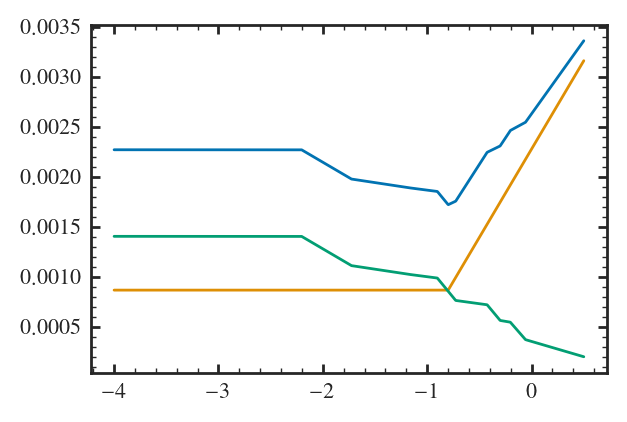

In [87]:
y = gcem.calc_y(Z, kind="all")
plt.plot(MH, y,)
y = gcem.calc_y(Z, kind="cc")
plt.plot(MH, y,)

y = gcem.calc_y(Z, kind="agb")
plt.plot(MH, y,)

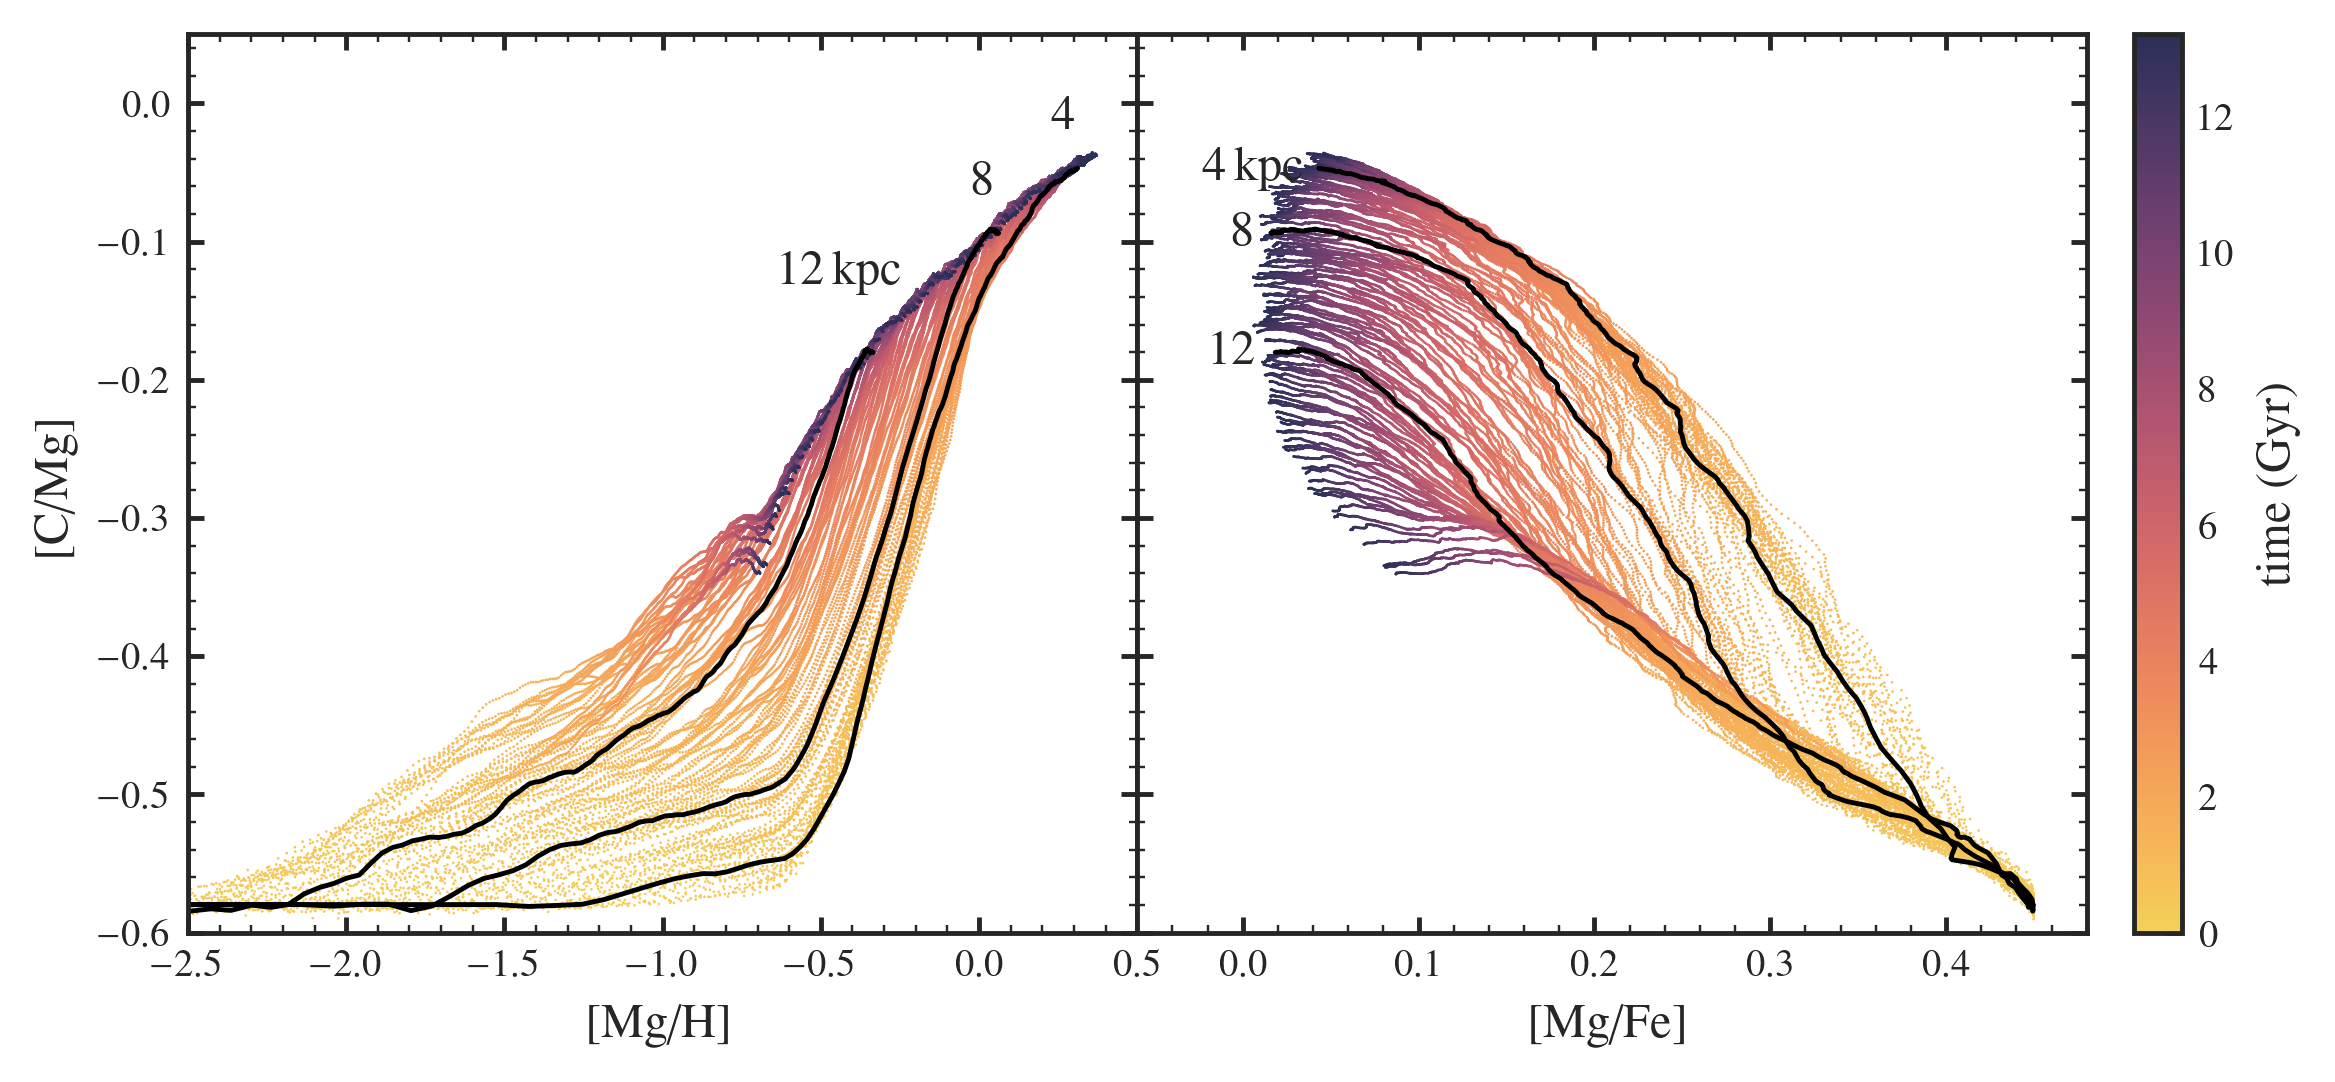

In [88]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3), dpi=350)

plt.sca(axs[0])
h = fiducial.history

coords = []

for R in [4,8, 12]:
    df = h[np.isclose(h.R, R - 0.05)]
    plt.plot(df.MG_H, df.C_MG, color="k")
    coords.append((
            df.MG_H.iloc[-1], 
            df.C_MG.iloc[-1]
        ))


texts = [
    "4",
    #"6",
    "8",
    #"10",
    r"12\,kpc"
]

for i in range(len(coords)):
    if i >= 2:
        offset = (-6, 12)
    else:
        offset = (-3, 6)
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="center", va="bottom",  
                        xycoords='data', textcoords='offset points', xytext=offset)

sns.scatterplot(h[(h.R > 2) & (h.R < 15.5)], x="MG_H", y="C_MG", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)
plt.xlim(-2.5, 0.5)
#plt.ylim(-0.45, 0.05)
#surp.plots.plot_annulus_at_t(fiducial, "MG_H", "C_MG", t=2, zorder=-2)



plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.sca(axs[1])



filt = fiducial.history["MG_H"] > -0.15
filt &= fiducial.history["MG_H"] < -0.05
h = fiducial.history

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

cb = arya.Colorbar(clim=(0, 13.2), label=r"time (Gyr)", cmap="arya_r", cax=cax)


label_Rs = [4,8,12]
coords = []

for R in np.sort(h.R.unique()[19:155]):
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    plt.scatter(dfa.O_FE, dfa.C_O, c=cb(dfa.time), s=0.3, ec="none", rasterized=True, zorder=1)
    if any(np.isclose(R+0.05, label_Rs)):
        coords.append((
            dfa["MG_FE"].iloc[-1], 
            dfa["C_MG"].iloc[-1]
        ))

        plt.plot(dfa["MG_FE"], dfa["C_MG"], color="k", zorder=2, lw=1)
    

texts = [
    "4\\,kpc",
   #"6",
    "8",
    #"10",
    r"12"
]


for i in range(len(coords)):
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="right",  va="center",
                        xycoords='data', textcoords='offset points', xytext=(-3, 0))
#     text.set_path_effects([mpl.patheffects.Stroke(linewidth=5, foreground='w'),
#                    mpl.patheffects.Normal()])
    
plt.xlim(-0.06, 0.48)
plt.ylim(-0.6, 0.05)
plt.xlabel("[Mg/Fe]")



plt.savefig("figures/all_the_tracks.pdf")

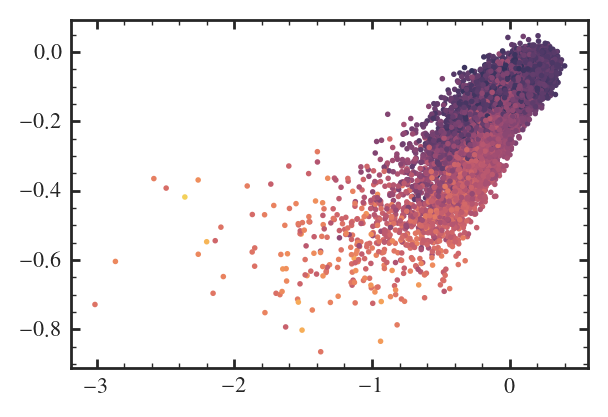

In [89]:
plt.scatter(fiducial.stars.MG_H, fiducial.stars.C_MG, s=1, c=fiducial.stars.MG_FE)

# F AGB
Here, I want to make plots of the AGB Fraction across the galaxy.

(array([1.000e+00, 1.000e+00, 1.000e+00, 6.000e+00, 1.400e+01, 4.800e+01,
        1.190e+02, 2.740e+02, 6.950e+02, 1.913e+03, 7.558e+03, 3.451e+03,
        1.317e+03, 7.010e+02, 1.850e+02, 5.500e+01, 1.600e+01, 4.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 4.25  ,  4.6175,  4.985 ,  5.3525,  5.72  ,  6.0875,  6.455 ,
         6.8225,  7.19  ,  7.5575,  7.925 ,  8.2925,  8.66  ,  9.0275,
         9.395 ,  9.7625, 10.13  , 10.4975, 10.865 , 11.2325, 11.6   ,
        11.9675, 12.335 , 12.7025, 13.07  , 13.4375, 13.805 , 14.1725,
        14.54  , 14.9075, 15.275 , 15.6425, 16.01  , 16.3775, 16.745 ,
        17.1125, 17.48  , 17.8475, 18.215 , 18.5825, 18.95  ]),
 <BarContainer object of 40 artists>)

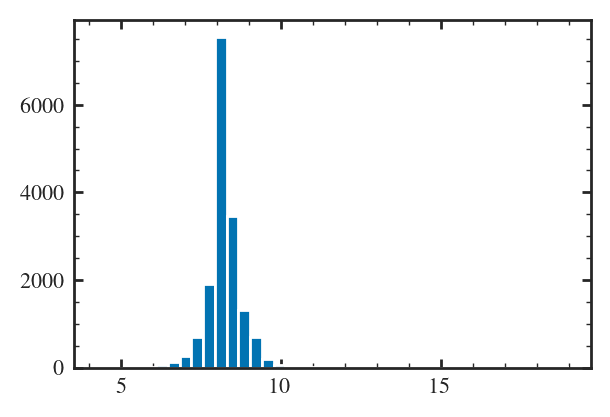

In [81]:
plt.hist(fiducial.stars.r_final, 40)

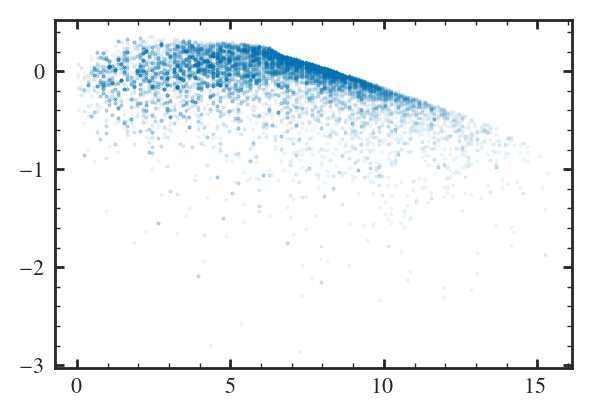

In [16]:
plt.scatter(fiducial.stars.r_origin, fiducial.stars.M_H, s=0.1, alpha=0.1)

In [17]:
from surp.simulation.properties import MH_grad, mass_loading

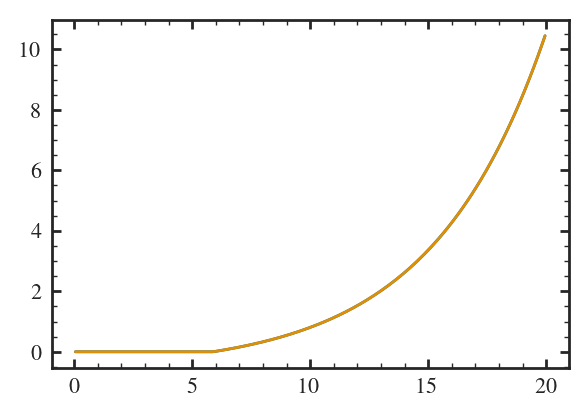

In [18]:
plt.plot(h.R, h.eta_0)
plt.plot(h.R, mass_loading(surp.MWParams())(h.R))

(array([ 222.,  654.,  664.,  873., 1263., 1358., 1486., 1659., 1578.,
        1751., 1705., 1050.,  903.,  512.,  252.,  215.,  124.,   57.,
          30.,    9.]),
 array([ 0.05 ,  0.815,  1.58 ,  2.345,  3.11 ,  3.875,  4.64 ,  5.405,
         6.17 ,  6.935,  7.7  ,  8.465,  9.23 ,  9.995, 10.76 , 11.525,
        12.29 , 13.055, 13.82 , 14.585, 15.35 ]),
 <BarContainer object of 20 artists>)

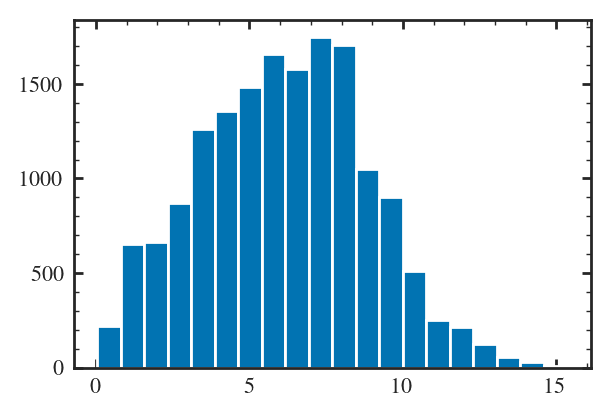

In [19]:
plt.hist(fiducial.stars.r_origin, 20)

In [20]:
h = fiducial.history

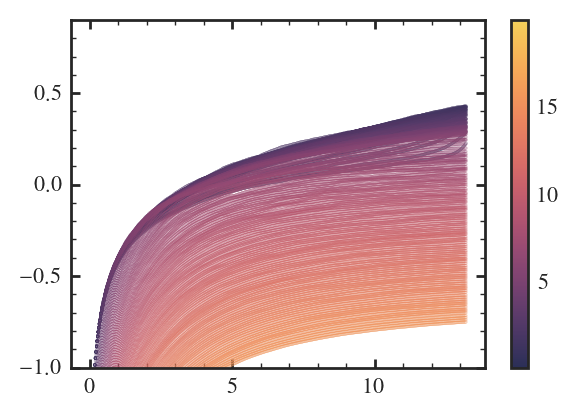

In [21]:
plt.scatter(h.time, h.M_H, c=h.R, s=0.005)
plt.ylim(-1, 0.9)
plt.colorbar()

In [22]:
h = fiducial.history
m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Mc = h["mass(c)"] # Msun

Zc = Mc / h["mgas"]
dt = h.time.unique()[1] # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

y_cc = vice.yields.ccsne.settings["c"]
yc_cc = y_cc(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (200, -1))

In [23]:
max(f_agb[f_agb < 0.5])

0.40796611241632125

(-1.0, 1.0)

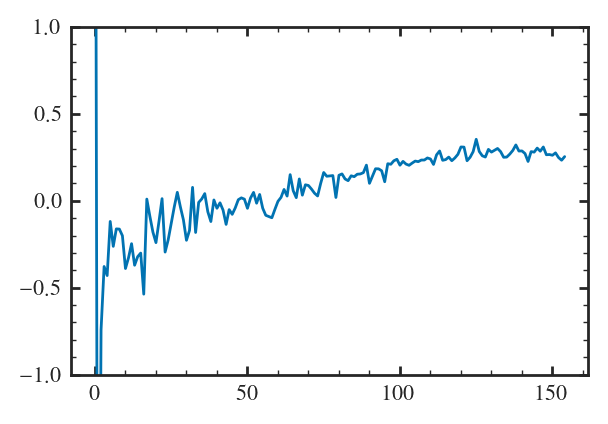

In [24]:
plt.plot(np.transpose(X)[-1,:])
plt.ylim(-1, 1)

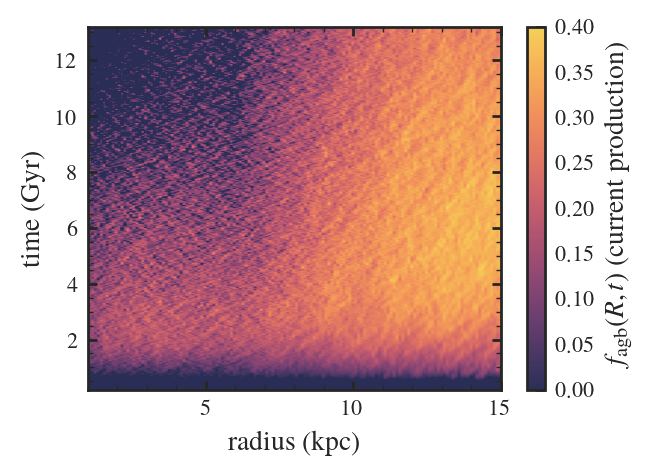

In [25]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
plt.imshow(np.transpose(X)[::-1], clim=(0, 0.4), extent=(0, 20, 0, 13.2), aspect="auto")
plt.xlim(1, 15)
plt.ylim(smooth*dt)

plt.colorbar(label=r"$f_{\rm agb}(R, t)$ (current production)")
plt.xlabel("radius (kpc)")
plt.ylabel("time (Gyr)")

plt.savefig("figures/f_agb_rt.pdf")

<Axes: xlabel='MG_H', ylabel='N_MG'>

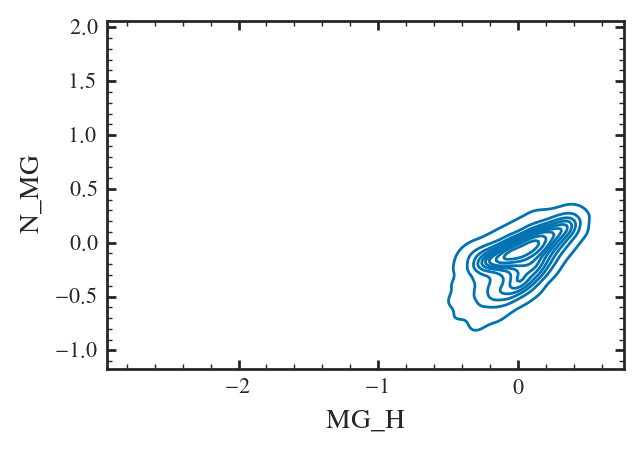

In [26]:
sns.kdeplot(surp.subgiants[~np.isnan(surp.subgiants.N_MG)], x="MG_H", y="N_MG")

Text(0, 0.5, '[N/Mg]')

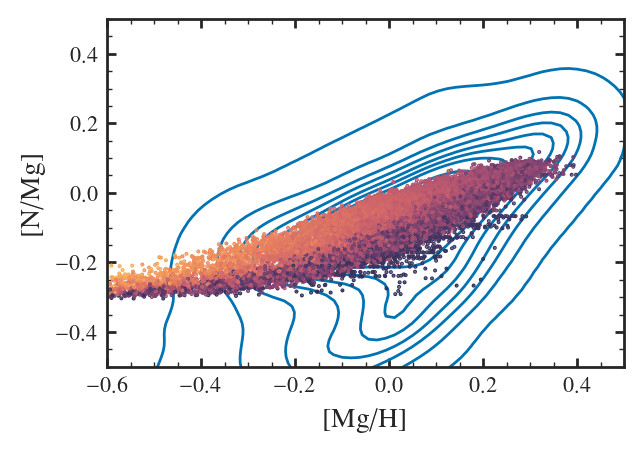

In [27]:
s = fiducial.stars

sns.kdeplot(surp.subgiants[~np.isnan(surp.subgiants.N_MG)], x="MG_H", y="N_MG")
plt.scatter(s["MG_H"], s["N_MG"], 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel("[Mg/H]")
plt.ylabel("[N/Mg]")


In [42]:
s = fiducial.stars

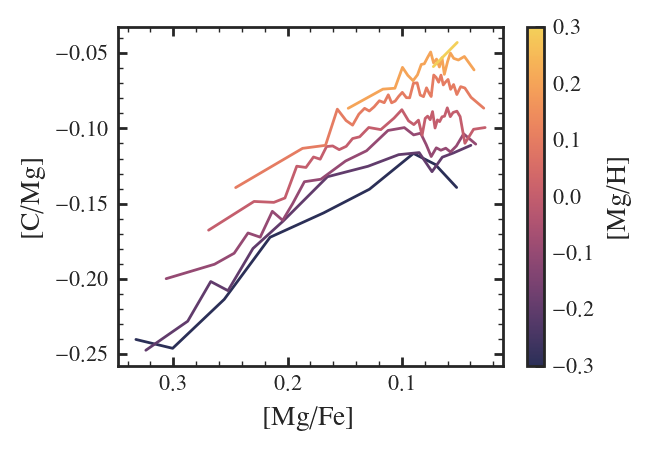

In [43]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), ax=plt.gca(), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    df = surp.plots.filter_metallicity(s, c=MH)
    
    arya.medianplot(df, x="MG_FE", y="C_MG", binsize=100, color=cb(MH), aes="line", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.tight_layout()
plt.savefig("figures/fiducial_caafe_binned.pdf")

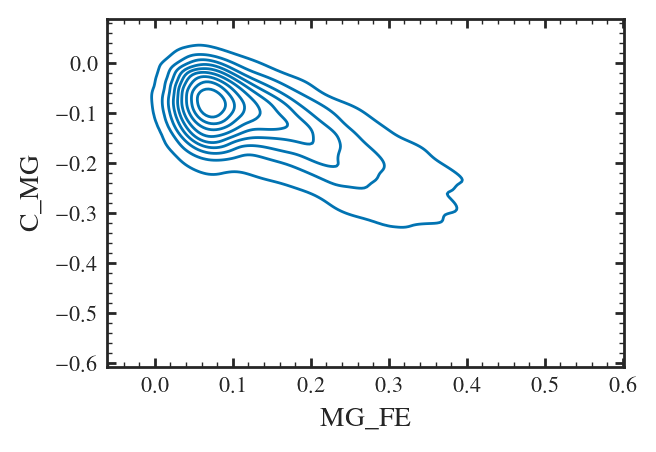

In [44]:
sns.kdeplot(s, x="MG_FE", y="C_MG");

(-0.1, 0.5)

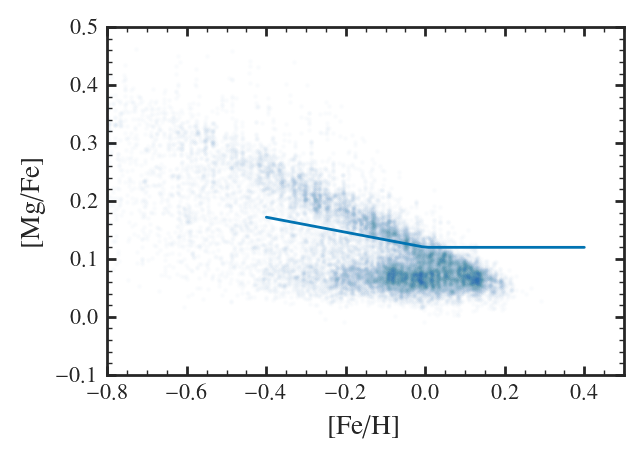

In [53]:
plt.scatter(s.FE_H, s.MG_FE, s=1, alpha=0.01)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
x = np.linspace(-0.4, 0.4)
y = gcem.mg_fe_cutoff(x)
plt.plot(x, y)
plt.xlim(-0.8, 0.5)
plt.ylim(-0.1, 0.5)

(-0.1, 0.5)

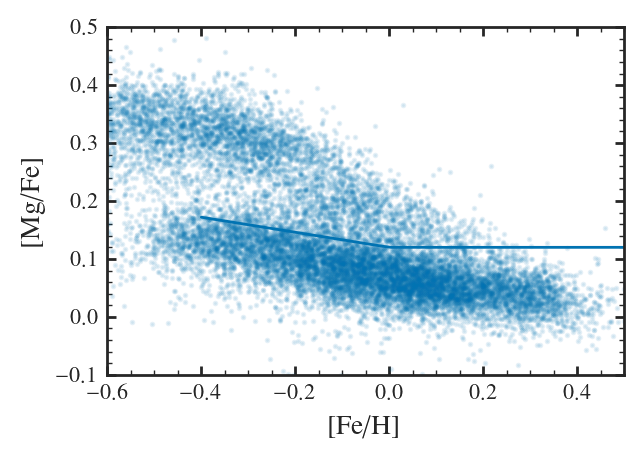

In [46]:
plt.scatter(surp.subgiants.FE_H, surp.subgiants.MG_FE, s=1, alpha=0.1)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
x = np.linspace(-0.4, 0.5)
y = gcem.mg_fe_cutoff(x)
plt.plot(x, y)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.1, 0.5)

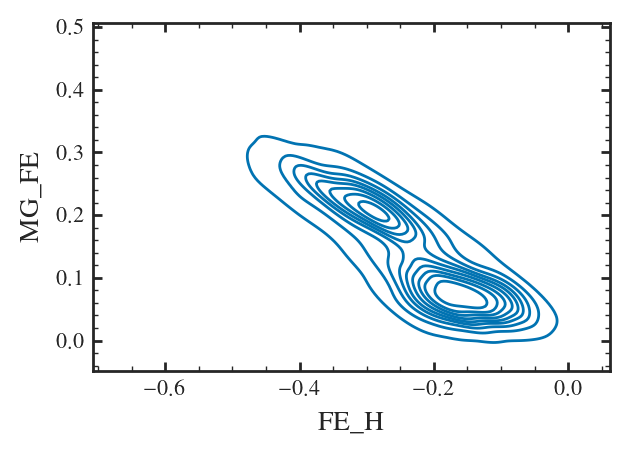

In [47]:
sns.kdeplot(surp.plots.filter_metallicity(s), x="FE_H", y="MG_FE");

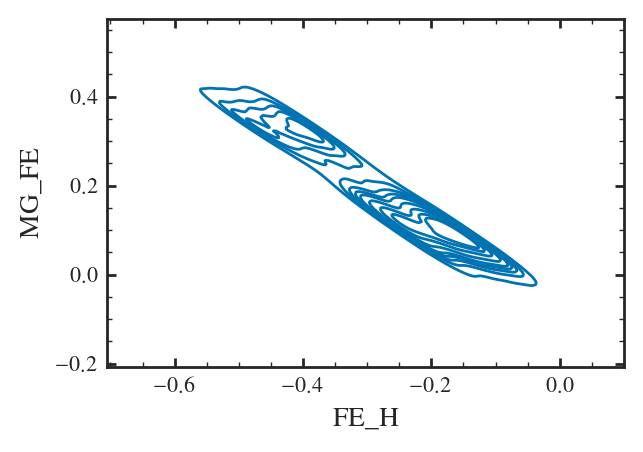

In [48]:
sns.kdeplot(surp.plots.filter_metallicity(surp.subgiants), x="FE_H", y="MG_FE");

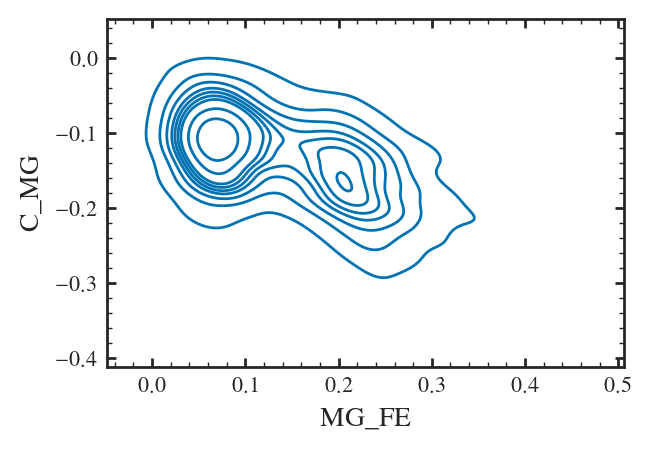

In [49]:
sns.kdeplot(surp.plots.filter_metallicity(s), x="MG_FE", y="C_MG");

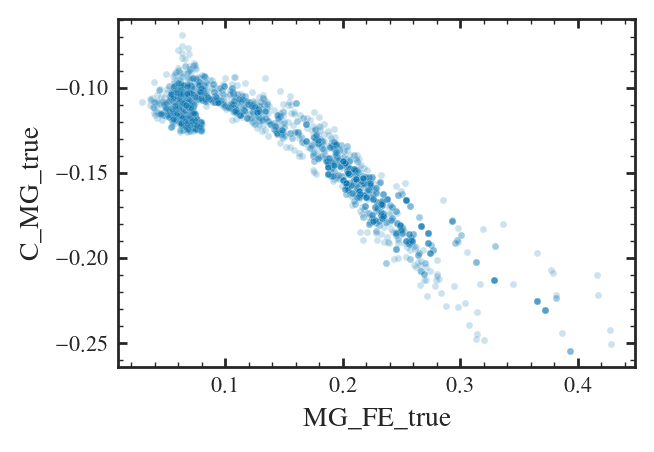

In [50]:
sns.scatterplot(surp.plots.filter_metallicity(s), x="MG_FE_true", y="C_MG_true", alpha=0.2);

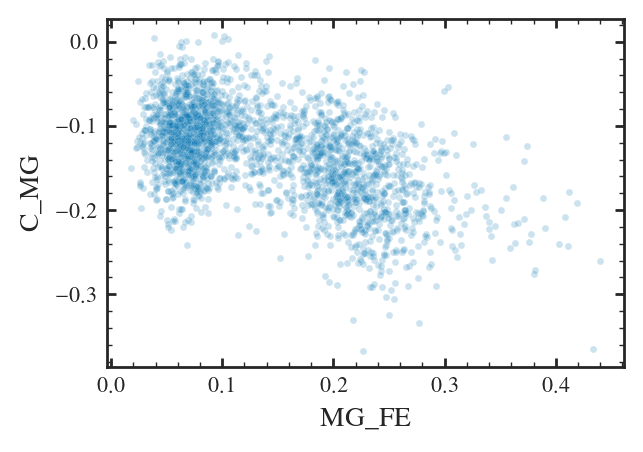

In [51]:
sns.scatterplot(surp.plots.filter_metallicity(s), x="MG_FE", y="C_MG", alpha=0.2);

<Axes: xlabel='MG_FE', ylabel='C_MG'>

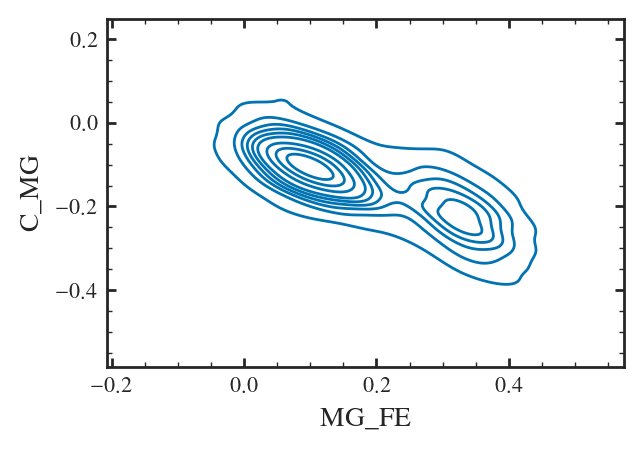

In [52]:
#sns.scatterplot(surp.plots.filter_metallicity(s), x="MG_FE", y="C_MG", alpha=0.2);
sns.kdeplot(surp.plots.filter_metallicity(surp.subgiants), x="MG_FE", y="C_MG",)